# Predicting the detail_views column based on other columns

**Author**: Wrijupan Bhattacharyya

**Description**: This notebook is prepared for a Used Cars analytics project. The data consist of one csv files-
  1. cleaned_data.csv - Contains the cleaned data on used car listings from the used car business (after removal of missing values and outliers)

  **Task**: There is one main task this notebook is accomplishing-

    1. Is it possible to predict detail views from the information given in the other columns?

Detail views is a numerical target, Hence the problem is treated as a Machine Learning regression problem.

**Metric**: Root-mean-squared-error (RMSE is used as the metric for regression)

**Standardization**: A ColumnTransformer object from Scikit-learn is used to apply different scaling logic to the columns

**Pipeline**: A Scikit-learn pipeline object is used for scaling and fitting the models to avoid data leakage

**Hyperparameter tuning**: A grid search using RandomizedSearchCV is used to scan the parameter space of the models and evaluation is performed using 5-fold cross-validation

**Models**: The following models have been built:

  1. Linear Regression
  2. Lasso
  3. Ridge
  4. Zero-inflated regression
  5. Random Forest
  6. XGBoost (best performance)

**Contents**: The notebook contains the following sections-


  1. Setting up the environment
  2. Loading the cleaned data
  3. Feature engineering
  4. Standization and normalization
  5. Diving the data into train and validation sets
  6. Training the models
  7. Evaluating the models



# 1. Setting up the environment




In [ ]:
#! pip install scikit-lego

In [2]:
##########################################################
# Import Python libraries
##########################################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

##########################################################
# Import Scikit-learn libraries
##########################################################
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVR, SVC
from sklearn.utils import class_weight
from sklearn.utils import resample


##########################################################
# Import XGBoost
##########################################################
import xgboost as xgb

##########################################################
# Import Sklego
##########################################################
#from sklego.meta import ZeroInflatedRegressor

### Mount google drive

In [3]:
from google.colab import drive
drive.mount('/gdrive')
# Navigate to the Google drive folder where the data is stored

Mounted at /gdrive


# 2. Importing the data

In [ ]:
data = pd.read_csv("./data/cleaned_data.csv")

In [ ]:
data = data.drop(columns=["Unnamed: 0"])

In [ ]:
data.head()

,product_tier,make_name,price,first_zip_digit,first_registration_year,search_views,detail_views,stock_days,ctr,created_month,created_dayofweek,created_day,deleted_year,deleted_month,deleted_dayofweek,deleted_day
0,Basic,Mitsubishi,16750,5,2013,3091.0,123.0,30,0.039793,7,1,24,2018,8,4,24
1,Basic,Mercedes-Benz,35950,4,2015,3283.0,223.0,52,0.067926,8,3,16,2018,7,1,10
2,Basic,Ford,1750,6,2003,1856.0,26.0,101,0.014009,7,4,20,2018,10,0,29
3,Basic,Mercedes-Benz,26500,3,2014,490.0,20.0,12,0.040816,8,1,28,2018,8,3,9
4,Basic,Volkswagen,24890,6,2017,125.0,6.0,2,0.048000,10,5,20,2018,10,0,22


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71933 entries, 0 to 71932
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   product_tier             71933 non-null  object 
 1   make_name                71933 non-null  object 
 2   price                    71933 non-null  int64  
 3   first_zip_digit          71933 non-null  int64  
 4   first_registration_year  71933 non-null  int64  
 5   search_views             71933 non-null  float64
 6   detail_views             71933 non-null  float64
 7   stock_days               71933 non-null  int64  
 8   ctr                      71933 non-null  float64
 9   created_month            71933 non-null  int64  
 10  created_dayofweek        71933 non-null  int64  
 11  created_day              71933 non-null  int64  
 12  deleted_year             71933 non-null  int64  
 13  deleted_month            71933 non-null  int64  
 14  deleted_dayofweek     

# 3. Feature engineering

### 3.1 Label encoding the product_tier column

In [ ]:
product_tier_map = {'Basic': 1, 'Plus': 2, 'Premium': 3} 

In [ ]:
data2 = data.copy(deep=True)

In [ ]:
data2['product_tier'] = data2['product_tier'].map(product_tier_map)

### 3.2 Mean encoding the make_name column

In [ ]:
make_name_map = (data2.groupby('make_name').mean()['detail_views']).to_dict()

In [ ]:
data3 = data2.copy(deep=True)

In [ ]:
data3['make_name'] = data3['make_name'].map(make_name_map)

In [ ]:
data3.head()

,product_tier,make_name,price,first_zip_digit,first_registration_year,search_views,detail_views,stock_days,ctr,created_month,created_dayofweek,created_day,deleted_year,deleted_month,deleted_dayofweek,deleted_day
0,1,80.203390,16750,5,2013,3091.0,123.0,30,0.039793,7,1,24,2018,8,4,24
1,1,95.870824,35950,4,2015,3283.0,223.0,52,0.067926,8,3,16,2018,7,1,10
2,1,54.377248,1750,6,2003,1856.0,26.0,101,0.014009,7,4,20,2018,10,0,29
3,1,95.870824,26500,3,2014,490.0,20.0,12,0.040816,8,1,28,2018,8,3,9
4,1,70.507825,24890,6,2017,125.0,6.0,2,0.048000,10,5,20,2018,10,0,22


### 3.3 Examining the correlation of detail_views with other columns

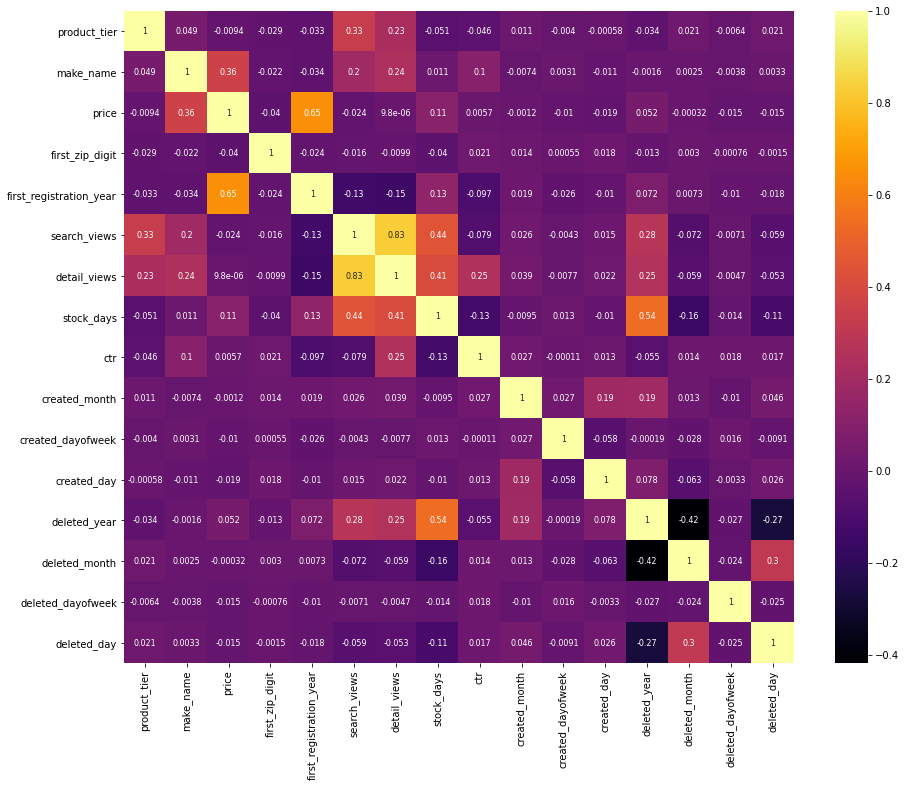

In [ ]:
plt.figure(figsize=(15, 12))

sns.heatmap(data3.corr(), 
            annot=True, 
            annot_kws={"fontsize":8}, 
            cmap='inferno')

plt.show()
plt.close()

### 3.4 detail_views vs deleted_month

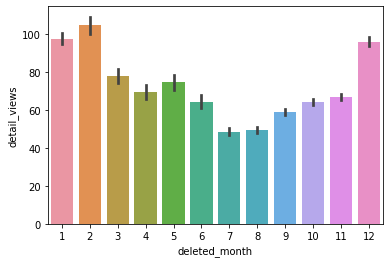

In [ ]:
sns.barplot(x='deleted_month', y='detail_views', data=data3)

The detail views depends upon the deleted month. Hence the deleted month column will be mean encoded with mean values of the detail views in a particular month. Note, that detail view does not increase linerly from 1 to 12. Hence the months are treated as categories instead of integers and mean-encoded.

In [ ]:
deleted_month_mask = (data3.groupby('deleted_month').mean()['detail_views']).to_dict()

data4 = data3.copy(deep=True)
data4['deleted_month'] = data4['deleted_month'].map(deleted_month_mask)

### 3.5 detail_views vs deleted year

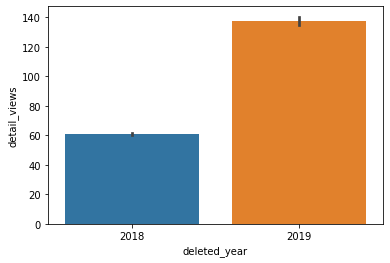

In [ ]:
sns.barplot(x='deleted_year', y='detail_views', data=data4)

2019 seems to have more detail_views. Hence the deleted year column will be binary encoded whether it is 2019 or not.

In [ ]:
data4['deleted_in_2019'] = data4['deleted_year'].apply(lambda x: x==2019)
data4.tail()

,product_tier,make_name,price,first_zip_digit,first_registration_year,search_views,detail_views,stock_days,ctr,created_month,created_dayofweek,created_day,deleted_year,deleted_month,deleted_dayofweek,deleted_day,deleted_in_2019
71928,1,123.097015,15740,8,2014,6895.0,230.0,99,0.033358,12,4,7,2018,64.191832,4,19,False
71929,1,54.041119,2950,6,2006,1175.0,16.0,25,0.013617,9,4,28,2018,64.191832,1,23,False
71930,1,70.507825,7850,8,2014,448.0,21.0,16,0.046875,4,2,11,2018,66.672814,2,21,False
71931,1,55.033768,13945,5,2011,1617.0,29.0,28,0.017934,4,0,9,2018,104.742030,5,10,False
71932,1,70.507825,38800,7,2018,55.0,2.0,1,0.036364,8,2,8,2018,58.935662,5,8,False


### 3.6 Deleting rest of the datetime columns
The columns 'created_month', 'created_dayofweek', 'deleted_dayofweek', 'deleted_year' does not seem to have a great impact on the detail_views. Hence these columns are deleted.

In [ ]:
data5 = data4.drop(columns=['created_month', 'created_dayofweek', 'created_day', 'deleted_dayofweek', 'deleted_year', 'deleted_day'])

In [ ]:
data5.head()

,product_tier,make_name,price,first_zip_digit,first_registration_year,search_views,detail_views,stock_days,ctr,deleted_month,deleted_in_2019
0,1,80.203390,16750,5,2013,3091.0,123.0,30,0.039793,49.558160,False
1,1,95.870824,35950,4,2015,3283.0,223.0,52,0.067926,48.634945,False
2,1,54.377248,1750,6,2003,1856.0,26.0,101,0.014009,64.191832,False
3,1,95.870824,26500,3,2014,490.0,20.0,12,0.040816,49.558160,False
4,1,70.507825,24890,6,2017,125.0,6.0,2,0.048000,64.191832,False


### 3.7 Drop the 'price' and 'first_zip_digit' columns as they have very low correlation with detail views

In [ ]:
data6 = data5.drop(columns=['price', 'first_zip_digit'])
data6.head()

,product_tier,make_name,first_registration_year,search_views,detail_views,stock_days,ctr,deleted_month,deleted_in_2019
0,1,80.203390,2013,3091.0,123.0,30,0.039793,49.558160,False
1,1,95.870824,2015,3283.0,223.0,52,0.067926,48.634945,False
2,1,54.377248,2003,1856.0,26.0,101,0.014009,64.191832,False
3,1,95.870824,2014,490.0,20.0,12,0.040816,49.558160,False
4,1,70.507825,2017,125.0,6.0,2,0.048000,64.191832,False


# 4. Dividing the data into training and validation sets

  1. The training set is used to train the model. The training set is validated using 5-fold cross-validation
  
  2. The validation set is not used in the modelling. It is used to independently test the model performance after training

In [ ]:
X = data6.drop(columns=['detail_views'])
y = data6[['detail_views']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


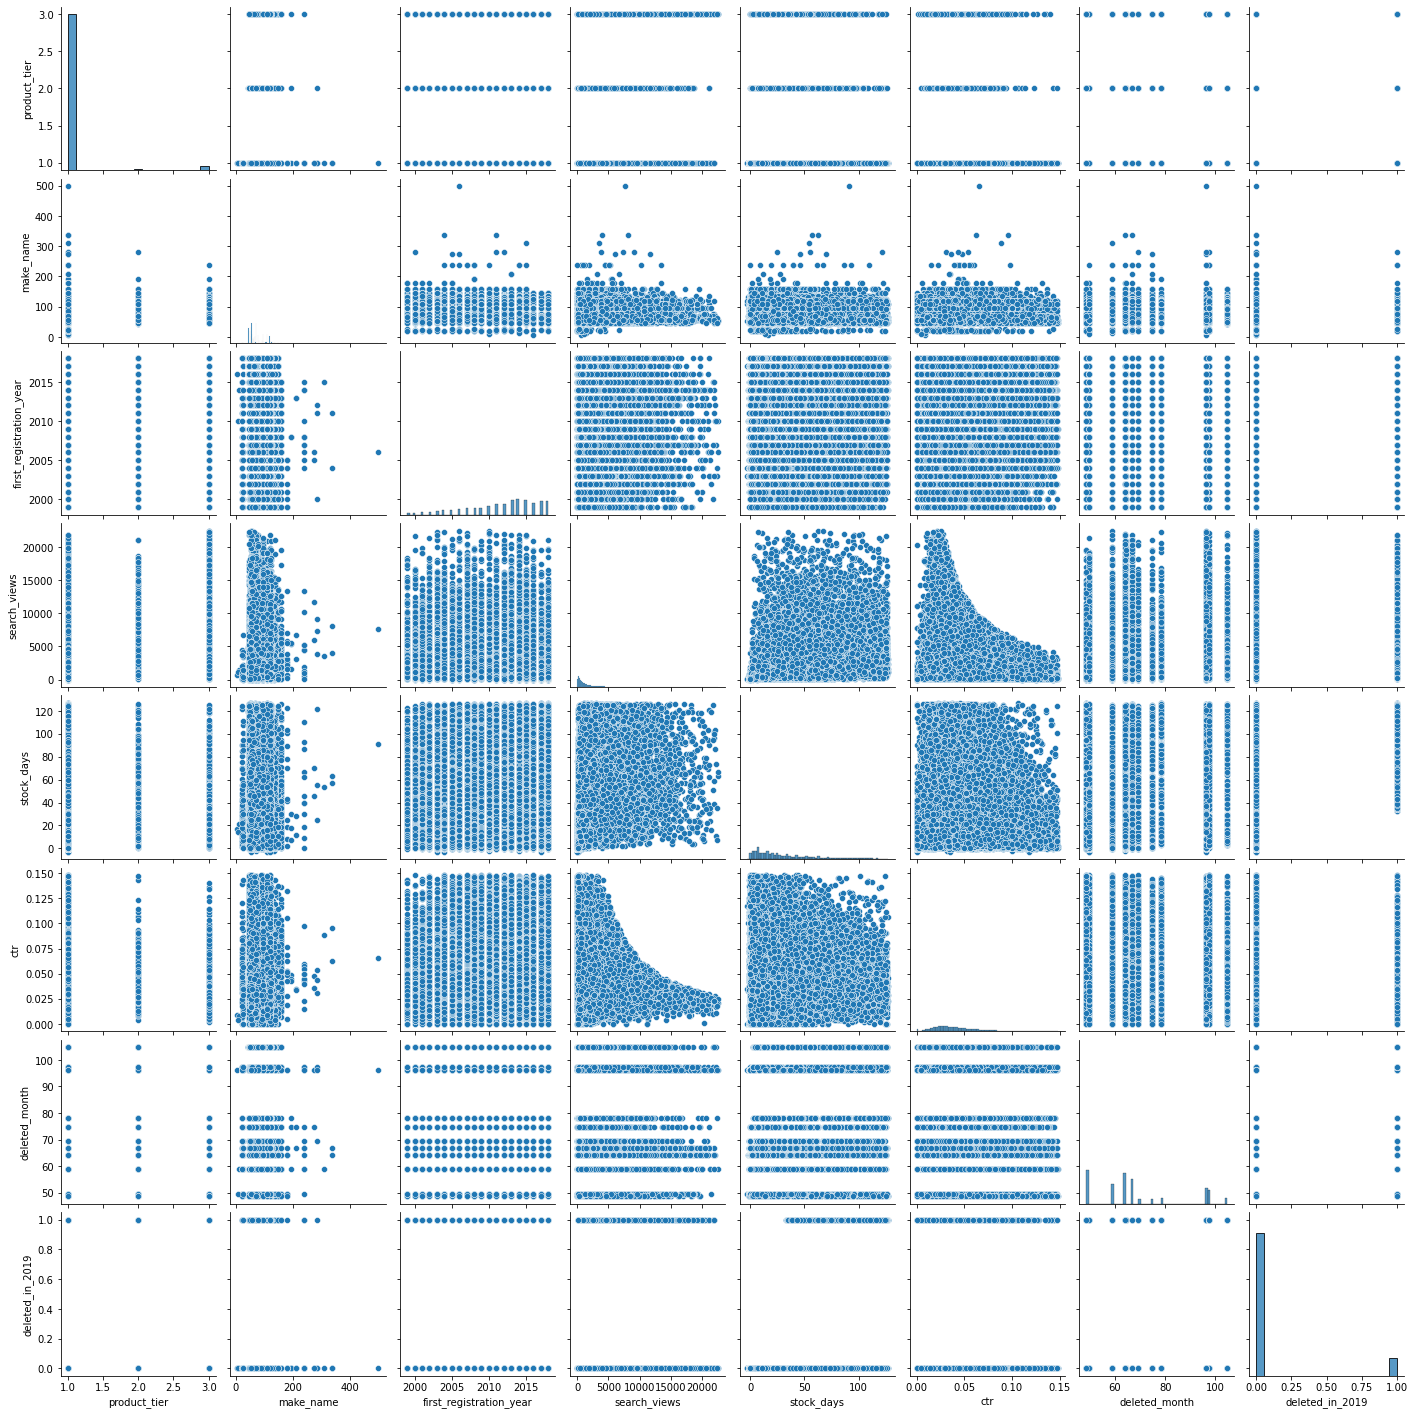

In [ ]:
sns.pairplot(X_train)

# 5. Normalization of the data

Three types of normalizations are used-

1. RobustScaler: Used for scaling the columns affected by outliers
2. MinMaxScaler: Used to scale columns which do not have a continuous distribution
3. StandardScaler: Used to normalize columns which have a more Gaussian-like distribution (the ctr column for example)

In order to avoid data leakage, the scalers are-

  1. Fitted to the train data
  2. The obtained statistics are applied to the test data

The target detail_views is not scaled in order to get the RMSE in the same units as detail_views. This might affect the performance of the linear models. For the tree-based models normalization does not affect the performance to a great extent.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


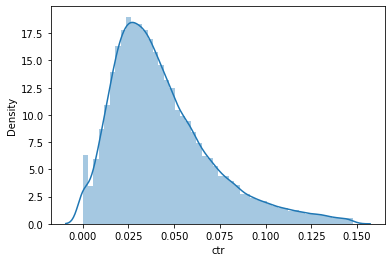

In [ ]:
sns.distplot(X_train['ctr'])

In [ ]:
minmax_cols = ['deleted_month', 'first_registration_year', 'product_tier']
rob_cols = ['make_name', 'search_views', 'stock_days', 'deleted_month']
std_cols = ['ctr', ]

In [ ]:
# A column transformer object is used to apply different scaling logic
# to the different columns
def feature_transformer(minmax_cols, rob_cols, std_cols):
    """
    Returns a transformer object
    """
    minmax_scaler = MinMaxScaler()
    std_scaler = StandardScaler()
    rob_scaler = RobustScaler()
    
    ct = ColumnTransformer([('minmax', 
                         minmax_scaler, 
                         minmax_cols
                        ), 
                        ('std', 
                          std_scaler, 
                          std_cols
                        ), 
                        ('rob', 
                         rob_scaler, 
                         rob_cols
                        )], 
                       remainder='passthrough')
    return ct

In [ ]:
# This preprocessor will be later used in data pipelining
preprocessor = feature_transformer(minmax_cols=minmax_cols,
                                   rob_cols=rob_cols,
                                   std_cols=std_cols
                                   )

# 6. Training the models

The following models are used for training the data:

  1. Linear Regression
  2. Lasso
  3. Ridge
  4. Zero-inflated Regressor
  5. Random Forest
  6. XGBoost

**Baseline model**: Mean or median predictions for the detail_views

**Metric**: Root-mean-squared-error (RMSE) is used as the evaulation metric for both K-fold cross-validation and also for model evaluation on the test data

### 6.1 Baseline model

In [ ]:
index = []
scores = {"RMSE": []}

In [ ]:
y_train_pred_mean = y_train.mean()

In [ ]:
y_train_pred_median = y_train.median()

In [ ]:
# Initialize dataframe for baseline predictions
baseline_predictions_train = pd.DataFrame()

# Train dataset model predictions
baseline_predictions_train['baseline_mean'] = np.repeat(y_train_pred_mean, repeats=X_train.shape[0])
baseline_predictions_train['baseline_median'] = np.repeat(y_train_pred_median, repeats=X_train.shape[0])

In [ ]:
MSE_mean = mean_squared_error(y_train.values, 
                         baseline_predictions_train['baseline_mean'].values)

index += ['Baseline_pred_mean']
scores['RMSE'].append(np.sqrt(MSE_mean))

df_scores = pd.DataFrame(scores, index=index)
df_scores.head()

,RMSE
Baseline_pred_mean,94.446783


In [ ]:
MSE_median = mean_squared_error(y_train.values, 
                                baseline_predictions_train['baseline_median'].values)

index += ['Baseline_pred_median']
scores['RMSE'].append(np.sqrt(MSE_median))

df_scores = pd.DataFrame(scores, index=index)
df_scores.head()

,RMSE
Baseline_pred_mean,94.446783
Baseline_pred_median,100.839653


### 6.2 Linear Regression

In [ ]:
lr_reg = make_pipeline(preprocessor,
                       LinearRegression()
                      )

index += ["Linear regression"]
cv_result = cross_validate(lr_reg, 
                           X_train, 
                           y_train, 
                           scoring='neg_root_mean_squared_error', 
                           cv=5, 
                           n_jobs=-1)

scores['RMSE'].append(-np.mean(cv_result['test_score']))

df_scores = pd.DataFrame(scores, index=index)
df_scores.head(20)

,RMSE
Baseline_pred_mean,94.446783
Baseline_pred_median,100.839653
Linear regression,42.150368


In [ ]:
lr_reg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('minmax', MinMaxScaler(),
                                                  ['deleted_month',
                                                   'first_registration_year',
                                                   'product_tier']),
                                                 ('std', StandardScaler(),
                                                  ['ctr']),
                                                 ('rob', RobustScaler(),
                                                  ['make_name', 'search_views',
                                                   'stock_days',
                                                   'deleted_month'])])),
                ('linearregression', LinearRegression())])

### 6.3 Lasso

In [ ]:
# Define  estimator
lasso = Lasso(random_state=42)

# Define pipeline
steps_lasso = [('scaler', preprocessor), ('lasso', lasso)]

pipe_lasso = Pipeline(steps_lasso)

# Implement Grid Search
params_lasso = {'lasso__alpha' : [0.001, 0.01, 0.1, 1., 10]
              }

rs_lasso = RandomizedSearchCV(pipe_lasso, 
                           param_distributions=params_lasso, 
                           n_iter=6, 
                           scoring='neg_root_mean_squared_error', 
                           n_jobs=-1, 
                           cv=5, 
                           random_state=42, 
                           verbose=2)

# Run grid search and cross-validation
rs_lasso.fit(X_train, y_train)

# Fill the score DF
index += ["Lasso"]

scores['RMSE'].append(- rs_lasso.best_score_)

df_scores = pd.DataFrame(scores, index=index)
df_scores.head()

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:289: UserWarning: The total space of parameters 5 is smaller than n_iter=6. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Fitting 5 folds for each of 5 candidates, totalling 25 fits


,RMSE
Baseline_pred_mean,94.446783
Baseline_pred_median,100.839653
Linear regression,42.150368
Lasso,42.149750


### 6.4 Ridge

In [ ]:
# Define  estimator
ridge = Ridge(random_state=42)

# Define pipeline
steps_ridge = [('scaler', preprocessor), ('ridge', ridge)]

pipe_ridge = Pipeline(steps_ridge)

# Implement Grid Search
params_ridge = {'ridge__alpha' : [0.001, 0.01, 0.1, 1., 10., 100.]
              }

rs_ridge = RandomizedSearchCV(pipe_ridge, 
                           param_distributions=params_ridge, 
                           n_iter=6, 
                           scoring='neg_root_mean_squared_error', 
                           n_jobs=-1, 
                           cv=5, 
                           random_state=42, 
                           verbose=2)

# Run grid search and cross-validation
rs_ridge.fit(X_train, y_train)

# Fill the score DF
index += ["Ridge"]

scores['RMSE'].append(- rs_ridge.best_score_)

df_scores = pd.DataFrame(scores, index=index)
df_scores.head()

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,RMSE
Baseline_pred_mean,94.446783
Baseline_pred_median,100.839653
Linear regression,42.150368
Lasso,42.149750
Ridge,42.150247


### 6.5 Zero-inflated Regressor
Some of the detail_views prediction could be zero. The Linear models usually do not perform well for predicting zeros. Hence a Zero-inflated Regressor from Sklego is used which operates in two steps:

1. First a classifier predicts whethr the output should be zero
2. If the the output is not zero the regressor predicts the output

In [ ]:
zir = ZeroInflatedRegressor(
    classifier=RandomForestClassifier(random_state=42),
    regressor=Ridge(random_state=42)
)

index += ["Zero-inflated regression"]
cv_result = cross_validate(zir, 
                           X_train, 
                           y_train, 
                           scoring='neg_root_mean_squared_error', 
                           cv=5, 
                           n_jobs=-1)

scores['RMSE'].append(-np.mean(cv_result['test_score']))

df_scores = pd.DataFrame(scores, index=index)
df_scores.head(20)

#cval_zir = evaluate_model(zir, X_train, y_train)

#print(-np.mean(cval_zir), np.std(cval_zir))

,RMSE
Baseline_pred_mean,94.446783
Baseline_pred_median,100.839653
Linear regression,42.150368
Lasso,42.149750
Ridge,42.150247
Zero-inflated regression,41.712572


### 6.6 Random Forest

In [ ]:
# Define  estimator
rf_reg = RandomForestRegressor(random_state=42)

# Define Pipeline
steps_rf_reg = [('scaler', preprocessor), ('rf_reg', rf_reg)]

pipe_rf_reg = Pipeline(steps_rf_reg)

# Implement Grid Search
params_rf_reg = {'rf_reg__n_estimators' : [50, 100, 150, 200,], 
                  'rf_reg__max_depth': np.arange(2, 6),  
                  'rf_reg__min_samples_leaf': np.arange(3, 7),
                  'rf_reg__max_samples': [0.5, 0.6, 0.7, 0.8]
                  }

rs_rf_reg = RandomizedSearchCV(pipe_rf_reg, 
                                param_distributions=params_rf_reg, 
                                n_iter=15, 
                                scoring='neg_root_mean_squared_error', 
                                n_jobs=-1, 
                                cv=5, 
                                random_state=42, 
                                verbose=2)

# Run grid search and cross-validation
rs_rf_reg.fit(X_train, y_train)

# Fill the score DF
index += ["RandomForest Regressor"]

scores['RMSE'].append(- rs_rf_reg.best_score_)

df_scores = pd.DataFrame(scores, index=index)
df_scores.head(30)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


,RMSE
Baseline_pred_mean,94.446783
Baseline_pred_median,100.839653
Linear regression,42.150368
Lasso,42.149750
Ridge,42.150247
Zero-inflated regression,41.712572
RandomForest Regressor,14.622272


### 6.7 XGBoost

In [ ]:
# Define  estimator
xgb_reg = xgb.XGBRegressor(random_state=42, 
                          objective='reg:squarederror',
                          booster='gbtree',
                         )

# Define pipeline
steps_xgb_reg = [('scaler', preprocessor), ('xgb_reg', xgb_reg)]

pipe_xgb_reg = Pipeline(steps_xgb_reg)

# Implement Grid Search
params_xgb_reg = {'xgb_reg__n_estimators' : [50, 100, 150, 200,], 
                  'xgb_reg__max_depth': np.arange(2, 6),  
                  'xgb_reg__min_samples_leaf': np.arange(3, 7),
                  'xgb_reg__learning_rate' : [0.001, 0.01, 0.1],
                  'xgb_reg__gamma' : [0.01, 0.1], 
                  'xgb_reg__reg_alpha' : np.logspace(-3, 1.4, 6),
                  'xgb_reg__reg_lambda' : np.logspace(-3, 1.4, 6),
                  }

rs_xgb_reg = RandomizedSearchCV(pipe_xgb_reg, 
                                param_distributions=params_xgb_reg, 
                                n_iter=15, 
                                scoring='neg_root_mean_squared_error', 
                                n_jobs=-1, 
                                cv=5, 
                                random_state=42, 
                                verbose=2)

# Run grid search and cross-validation
rs_xgb_reg.fit(X_train, y_train)

# Fill the score DF
index += ["XGBoost Regressor"]

scores['RMSE'].append(- rs_xgb_reg.best_score_)

df_scores = pd.DataFrame(scores, index=index)
df_scores.head(20)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


,RMSE
Baseline_pred_mean,94.446783
Baseline_pred_median,100.839653
Linear regression,42.150368
Lasso,42.149750
Ridge,42.150247
Zero-inflated regression,41.712572
RandomForest Regressor,14.622272
XGBoost Regressor,2.409411


# 7. Evaluating the models

### Linear Regression Predictions

In [ ]:
y_pred_linreg = lr_reg.predict(X_test)

RMSE_linreg = np.sqrt(mean_squared_error(y_test.values, y_pred_linreg))

### Lasso Regression predictions

In [ ]:
y_pred_lasso = rs_lasso.predict(X_test)

RMSE_lasso = np.sqrt(mean_squared_error(y_test.values, y_pred_lasso))

### Ridge Regression predictions

In [ ]:
y_pred_ridge = rs_ridge.predict(X_test)

RMSE_ridge = np.sqrt(mean_squared_error(y_test.values, y_pred_ridge))

### Random Forest predictions

In [ ]:
y_pred_rf = rs_rf_reg.predict(X_test)

RMSE_rf = np.sqrt(mean_squared_error(y_test.values, y_pred_rf))

### XGBoost predictions

In [ ]:
y_pred_xgb = rs_xgb_reg.predict(X_test)

RMSE_xgb = np.sqrt(mean_squared_error(y_test.values, y_pred_xgb))

### Summary of the predicted test set RMSE

In [ ]:
df_rmse = pd.DataFrame()

df_rmse['Model'] = ['Linear Regression', 
                    'Lasso Regression', 
                    'Ridge Regression', 
                    'RandomForest Regression', 
                    'XGBoost Regression']

df_rmse['RMSE'] = [RMSE_linreg, 
                   RMSE_lasso, 
                   RMSE_ridge, 
                   RMSE_rf, 
                   RMSE_xgb]


df_rmse.head()

,Model,RMSE
0,Linear Regression,41.614345
1,Lasso Regression,41.612276
2,Ridge Regression,41.613796
3,RandomForest Regression,14.978519
4,XGBoost Regression,2.233992
